In [5]:
#@title Install MapboxGL,  Kepler, H3, etc.
%%capture
!pip3 install mapboxgl keplergl h3
!pip3 install geopandas geojson pandas
!pip3 install geohash polygon_geohasher

In [6]:
#@title Import modules
#@markdown NumPy
import numpy as np
#@markdown Pandas and GeoPandas
import geopandas as gpd,  pandas as pd
#@markdown Uber's H3
from h3 import h3
#@markdown Geohash tools
from polygon_geohasher.polygon_geohasher import geohash_to_polygon, geohash_to_polygon
#@markdown JSONs and GeoJSONs tools
from geojson import Feature, FeatureCollection
from json import dumps
#@markdown MapboxGL imports, & token
from mapboxgl.viz import *
from mapboxgl.utils import *
token = 'pk.eyJ1IjoiaW1hbnVlbGdlb3RhYiIsImEiOiJjazM4d2w0NjYwY3E2M2RvMWVzYWpmbW00In0.yqqqM-7riKogTBKuiHVZSg' #IM
#@markdown Colab's "files" (for download)
from google.colab import files

In [7]:
#@title Authenticate
from google.colab import auth
_ = auth.authenticate_user()

In [8]:
#@title Google Big Query Client and Mapbox authentification
from google.cloud import bigquery
#@title Client credentials
client = bigquery.Client(project='geotab-bootcamp')

In this Notebook, we will be going through 2 mapping exercises:
*   We will map temperatures (from Geotab's public data desribed in data.geotab.com) in the USA, and by creating H3 polygons in California  using MapboxGL
*   Then we will look at Trips data and convexhulls from the Intelligent Zoning presentation. We will first use then KeplerGL to render the maps. The objective will be to find the HQ, notice something interesting going on in the trips around the HQ, and understand what is going on there. 



#Temperatures with Mapbox

Let's collect temperatures from **data.geotab.com**
*   We will be averaging the Temperatures (F) by State
*   We will need to get the borders of the States to map them properly. The US Census data will be our source for this



###Temperatures in the USA

In [9]:
temperature=''' 
SELECT 
    Country
    , State
    ,	avg(Temperature_F) as Temperature

FROM `geotab-public-intelligence.Weather.Temperature`
WHERE Country  = 'United States of America (the)' 
GROUP BY 1,2
'''
temperature_df = client.query(temperature).to_dataframe()
temperature_df.head(2)

,Country,State,Temperature
0,United States of America (the),Louisiana,83.623789
1,United States of America (the),Georgia,81.233030


###Polygon States Boundaries from the US Census Bureau

We will use the state boarders as defined by US Census Bureau:


*   We download the Zip file from the US Census website
*   We "unzip" the file into the .shp files that will be imported into the dataframe



In [10]:
import urllib.request
print('Beginning file download ...\n')
url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip'
urllib.request.urlretrieve(url, 'cb_2018_us_state_20m.zip')
print('\nDownload finished\n')
print('Extracting files ...\n')
!unzip cb_2018_us_state_20m.zip
print ('\nExtraction finished')

Beginning file download ...


Download finished

Extracting files ...

Archive:  cb_2018_us_state_20m.zip
  inflating: cb_2018_us_state_20m.shp.ea.iso.xml  
  inflating: cb_2018_us_state_20m.shp.iso.xml  
  inflating: cb_2018_us_state_20m.shp  
  inflating: cb_2018_us_state_20m.shx  
  inflating: cb_2018_us_state_20m.dbf  
  inflating: cb_2018_us_state_20m.prj  
 extracting: cb_2018_us_state_20m.cpg  

Extraction finished


In [11]:
states_df = gpd.read_file('cb_2018_us_state_20m.shp')
states_df.head(2)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."


###Merging temperature and shape tables then creating a Geojson 
Now we will combine both files into one dataframe.
MapboxGL uses GeoJSON format as an input, therefore we need to generate the data in the required format

In [12]:
temp_df = pd.merge(temperature_df, states_df, how='left' , left_on = 'State', right_on='NAME')

# geometry=temp_df['geometry'].map(loads)
temperature_states_df = gpd.GeoDataFrame( 
    temp_df,
    crs={'init': 'epsg:4326'},
    geometry=temp_df['geometry']
    )
temperature_states_df['Temperature']=temperature_states_df['Temperature'].round(0)
temperature_states_df.head(2)


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,Country,State,Temperature,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,United States of America (the),Louisiana,84.0,22,01629543,0400000US22,22,LA,Louisiana,00,1.118976e+11,2.375362e+10,"POLYGON ((-94.04305 32.69303, -94.04303 32.797..."
1,United States of America (the),Georgia,81.0,13,01705317,0400000US13,13,GA,Georgia,00,1.494820e+11,4.422936e+09,"POLYGON ((-85.60516 34.98468, -85.47434 34.983..."


In [13]:
features = []
for index, row in temperature_states_df.iterrows():
    features.append(Feature(id=None, 
                            geometry=row['geometry'],
                            properties={'State': row['State'],
                                        'Temperature(F)': row['Temperature']
                                        })) 
temperature_fc = FeatureCollection(features)


###Check Temperature distribution and create to decide color-stops in the map

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ee56565c0>]],
      dtype=object)

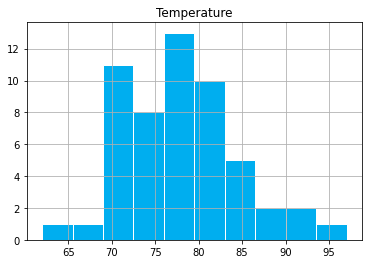

In [14]:
temperature_states_df.hist(column='Temperature', color='#00aeef', edgecolor='white')

###Map of temperature by states

We are going to build step by step:
*   Render a 2D map
*   View that map in 3D
*   Modify the height of the Polygons in proportion of temperature

Note: we could use one field for colour and a totally different one for height

Play with the options to improve the map




*   Documentation: https://readthedocs.com/projects/mapbox-mapbox/downloads/pdf/latest/
*   Examples: https://github.com/mapbox/mapboxgl-jupyter/tree/master/examples/notebooks



In [18]:
viz = ChoroplethViz(temperature_fc, 
                    access_token=token,
                    color_property='Temperature(F)',
                    color_stops=create_color_stops([65, 75, 85], colors=['#abdda4','#ffffbf','#d7191c' ]), #colors='YlOrRd'),
                    color_function_type='interpolate',
                    line_width=1,
                    line_opacity=0.9,
                    opacity=0.8,
                    center=(-96, 37.8),
                    zoom=3,
                    below_layer='waterway-label',
                    legend_layout='horizontal',
                    legend_key_shape='bar',
                    legend_key_borders_on=False
                    )

# adjust view angle
# viz.bearing = -15
# viz.pitch = 45

# add extrusion to viz using interpolation keyed on density in GeoJSON features
# viz.height_property = 'Temperature(F)'
# viz.height_stops = create_numeric_stops([65, 70, 80, 85, 90, 95], 0, 500000)
# viz.height_function_type = 'interpolate'

viz.show()

### Temperatures in California

In [19]:

temperature_cal = """

SELECT 
      Geohash
     , Avg(Temperature_F) as Temperature
     , (Latitude_SW  + Latitude_NE ) / 2 as Latitude
     , (Longitude_SW + Longitude_NE) / 2 as Longitude

FROM    `geotab-public-intelligence.Weather.Temperature`
WHERE    Country = 'United States of America (the)'
  AND    State = "California"                      
GROUP BY  1, 3, 4         
"""

cal_df = client.query(temperature_cal).to_dataframe()
cal_df.head(10)

,Geohash,Temperature,Latitude,Longitude
0,9q9yurb,94.800000,37.792285,-121.101605
1,9qh3mpd,87.592000,34.011615,-117.550275
2,9q5d21u,81.304000,34.155805,-118.821945
3,9mupwhu,79.571429,33.688890,-117.855145
4,9q9jyps,76.512000,37.615125,-122.073895
5,9qcbxkv,85.375000,38.083420,-120.962905
6,9q7hvjg,91.008000,36.023485,-119.306715
7,9q9nm37,77.068000,37.668685,-122.108230
8,9q8ympd,66.305263,37.703015,-122.472155
9,9q7nerf,91.477778,36.342085,-119.384995


In [20]:
def encode_hexagon(lat, lon, resolution):
    return {"type": "Polygon",
            "coordinates": [h3.h3_to_geo_boundary(h3.geo_to_h3(lat, lon, res=resolution), geo_json=True)]
           }

def encode_hexagon_str(lat, lon, resolution):
    return h3.geo_to_h3(lat, lon, resolution=resolution)

def hex_from_h3(h3_str):
    return {"type": "Polygon",
            "coordinates": [h3.h3_to_geo_boundary(h3_str, geo_json=True)]
           }

encode_hexagon_v = np.vectorize(encode_hexagon)
encode_hexagon_str_v = np.vectorize(encode_hexagon_str)
hex_from_h3_v = np.vectorize(hex_from_h3)

cal_df['HexagonStr'] = encode_hexagon_str_v(cal_df['Latitude'], cal_df['Longitude'], 5)
cal_df_hex = cal_df[['Temperature', 'HexagonStr']].groupby(by='HexagonStr', as_index=False).mean().dropna().reset_index(drop=True)
cal_df_hex['Hexagon'] = cal_df_hex.apply(lambda x: hex_from_h3(x['HexagonStr']), axis=1)
cal_df_hex['Temperature'] = cal_df_hex['Temperature'].round(1)
cal_df_hex.head(2)

features = []
for i, row in cal_df_hex.iterrows():
    features.append(Feature(geometry=row['Hexagon'], properties={'H3': row['HexagonStr'], 'Temperature': row['Temperature']}))
feature_collection = FeatureCollection(features)

color_stops =[[-80.0, '#e3e3e3'],
              [-60.0, '#f4a5f3'],
              [-40.0, '#8d1c8d'],
              [-30.0, '#2b1b69'],
              [-20.0, '#5751ac'],
              [-10.0, '#4176be'],
              [0.0,   '#4eb195'],
              [10.0,  '#5bca4e'],
              [40.0,  '#b7da42'],
              [50.0,  '#e1ce3a'],
              [60.0,  '#e19f43'],
              [70.0,  '#db6c55'],
              [80.0,  '#b83667'],
              [100.0, '#6b1428'],
              [120.0, '#2b0001']]


cal_viz = ChoroplethViz(feature_collection,
                access_token=token,
                color_property='Temperature',
                color_stops=color_stops,
                color_function_type='interpolate',
                style='mapbox://styles/imanuelgeotab/ck5790p96039j1co3quia8m24',
                opacity=0.5,
                line_width=0.2,
                line_opacity=0.025,
                line_color='black',       
                width='1080px',
                height='540px',
                center=(cal_df.Longitude.median(), cal_df.Latitude.median()),
                zoom=5,
                add_snapshot_links=False,
                legend_layout='horizontal',
                legend_key_shape='bar',
                legend_key_borders_on=False)


In [21]:
cal_viz.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ecd2b9550>]],
      dtype=object)

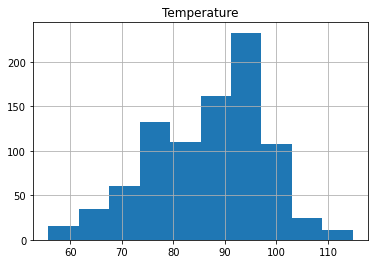

In [22]:
cal_df_hex.hist(column='Temperature')

In [23]:
# adjust view angle
cal_viz.bearing = -15
cal_viz.pitch = 45


# add extrusion to viz using interpolation keyed on density in GeoJSON features
cal_viz.height_property = 'Temperature'
cal_viz.height_stops = create_numeric_stops ( [ 60, 70, 80, 90, 100, 110], 0, 100000)
cal_viz.height_function_type = 'interpolate'
cal_viz.opacity=0.9
cal_viz.show()

#Trips with KeplerGL




### Trips data

In [24]:
#@title Run the query for trips
Trips = 'select * from `geotab-bootcamp.Dashboarding.Trips`'

trips_df = client.query(Trips).to_dataframe()
trips_df['StartTime']=trips_df['StartTime'].astype(str)
trips_df['StopTime']=trips_df['StopTime'].astype(str)
trips_df.head(2)

,HardwareId,UniqueId,StartTime,StopTime,StartLatitude,StartLongitude,StartGeohash,StopLatitude,StopLongitude,StopGeohash,DrivingDuration,StopDuration,IdlingDuration,MaxSpeed,Distance,Year,Month,Day,HourStart,HourStop,StartGeohash7,StopGeohash7,PreviousStopDuration,StartPoint,StopPoint
0,7,2470438_550610494_2018-04-24_04:23:13UTC,2018-04-24 04:23:13.063000+00:00,2018-04-24 04:23:13.063000+00:00,43.760155,-79.469315,dpz2zwk1q,43.760155,-79.469315,dpz2zwk1q,0.0,23725.0,0.0,0.0,0.0,2018,4,24,0,0,dpz2zwk,dpz2zwk,32626.063,POINT(-79.4693146 43.7601547),POINT(-79.4693146 43.7601547)
1,7,2477609_550610494_2018-04-25_04:28:38UTC,2018-04-25 04:28:38.063000+00:00,2018-04-25 04:28:38.063000+00:00,43.760307,-79.469440,dpz2zwk47,43.760307,-79.469440,dpz2zwk47,0.0,9323.0,0.0,0.0,0.0,2018,4,25,0,0,dpz2zwk,dpz2zwk,63000.000,POINT(-79.46944 43.7603073),POINT(-79.46944 43.7603073)


###Stop Location Clusters

In [25]:
#@title Run the query for convexhulls
clusters = '''
SELECT DISTINCT Cluster, geometry
FROM `geotab-bootcamp.Dashboarding.Convexhull`
'''

clusters_df = client.query(clusters).to_dataframe()
clusters_df.head(2)


,Cluster,geometry
0,0,"POLYGON ((-82.64578 42.0630531, -82.6453247 42..."
1,1,"POLYGON ((-80.33485 43.12778, -80.33503 43.128..."


### KeplerGL
Kepler allows to upload the data, and interactively work with the Map: 

*   Can you view the Polygons from the Parking Convexhulls?
*   Can we view the Trip Arcs?
*   Use the "brush" option in "Interactions: the Arcs will appear as you move your mouse
*   Let's spot the HQ by looking at the most common location
*   Can we check that overtime, this location remains the most common begin/end of trip
*   What happens when the truck leave the HQ?
*   Can you find out what is at that location?
*   Based on this, what do you think the manager could get for drivers birthday?



In [26]:
from keplergl import KeplerGl

w2 = KeplerGl(height = 400 ,
              data={'Trips data': trips_df, 
                    'Locations data': clusters_df})

w2.save_to_html(data={'Trips data': trips_df, 
                      'Locations data': clusters_df},
                file_name='Kepler_Trips.html')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to Kepler_Trips.html!


In [27]:
files.download('Kepler_Trips.html')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>